# Generic Cross-Band RFI Model (S / X / Ku / K / Ka)

This notebook implements the final **generic Radio Frequency Interference (RFI) model** used in the thesis to compare **S, X, Ku, K, and Ka bands** under a unified **ITU-R-aligned framework**. It generates all link-level and statistical results that appear in the paper/thesis.

## Model Overview

The model:

- Follows **ITU-R S.1325-3** for multi-interferer geometry, aggregate interference power, and C/I statistics.  

- Uses **ITU-R SA.609** and **SA.1157** as the protection rulebooks for near-Earth and deep-space SRS links, expressed via interference spectral-density limits and allowed time fractions.  

Produces cross-band, time-varying metrics such as:

-   Baseline SNR and SNR with interference
-   Carrier-to-Interference ratio ( C/I )
-   SNR loss ( \\Delta \\mathrm{SNR} )
-   Probability that ( \\Delta \\mathrm{SNR} > \\Delta ) (SA.609 / SA.1157-style time fractions)


## Scope and Purpose

This notebook is **results-oriented**:

- All scenarios correspond to the final **S-, X-, Ku-, K-, and Ka-band** case studies.
- All tables and plots are intended to be copied directly into the **thesis/paper**.
- Earlier “toy” notebooks are treated as **exploratory** and are **not used here**.


## 2. Model overview and notation

The generic RFI model describes a desired carrier and one or more interfering signals received by a satellite or ground terminal. It uses a **single set of equations** for all bands; only the numerical parameters (frequency, antenna gains, bandwidth, system temperature, geometry) change between S, X, Ku, K, and Ka cases. [file:1][file:4]

### 2.1 Desired carrier and noise

For a given victim link, the received carrier power (C) (in dBW) is [ C = \text{EIRP}\text{tx} + G\text{rx}(\theta) - L_\text{path} - L_\text{other} ] where (\text{EIRP}\text{tx}) is the transmit EIRP in dBW, (G\text{rx}(\theta)) is the receive antenna gain towards the desired direction (typically near boresight), (L_\text{path}) is the free‑space + atmospheric path loss in dB, and (L_\text{other}) collects remaining losses (polarisation, implementation, pointing). 

The thermal noise power (N) in a receiver of noise temperature (T_\text{sys}) and bandwidth (B) is [ N = 10 \log_{10}!\big(k_\text{B} T_\text{sys} B\big) ] where (k_\text{B}) is Boltzmann’s constant. The baseline signal‑to‑noise ratio without interference is [ \text{SNR}_0 = C - N. ] 

### 2.2 Interference and combined SNR

Each interferer \(i\) contributes a received power \(I_i\) at the victim receiver. This is computed with the same link‑budget structure as for \(C\), but using the interferer’s EIRP, path loss, and the off‑axis receive gain \(G_\text{rx}(\theta_i)\) obtained from an ITU‑R S.1528‑type antenna pattern.

The **aggregate interference power** is
\[
I_\text{agg} = 10 \log_{10}\!\left( \sum_i 10^{I_i/10} \right),
\]
and the **carrier‑to‑interference ratio** is
\[
\frac{C}{I} = C - I_\text{agg}.
\]
The **SNR with interference** is obtained by linear combination of noise and interference:
\[
\text{SNR}_\text{I} = 10 \log_{10}\!\left( \frac{10^{C/10}}{10^{N/10} + 10^{I_\text{agg}/10}} \right).
\]

The **SNR loss** due to interference is finally defined as
\[
\Delta \text{SNR} = \text{SNR}_0 - \text{SNR}_\text{I},
\]
which is non‑negative when interference degrades the link. This quantity is the central performance metric used in later sections and is directly linked to the ITU‑R SA.609 and SA.1157 protection criteria via probability‑of‑exceedance conditions.


## 3. ITU‑R protection criteria in probabilistic form

The engine evaluates interference against ITU‑R protection criteria by translating spectral‑density or power limits into **time‑fraction constraints** on \(\Delta \text{SNR}\) or on interference‑to‑noise ratios. This unifies deep‑space and near‑Earth SRS with FSS‑style CI analysis.

### 3.1 Near‑Earth SRS (SA.609)

For near‑Earth space research service links, ITU‑R SA.609 specifies interference spectral‑density limits \(I_0\) (typically around \(-216\) dBW/Hz in 1–20 GHz) and **very small allowed exceedance fractions** over long‑term operation.

In the model, a near‑Earth SRS link is considered compliant if
\[
P\!\left[ \Delta \text{SNR}(t) > \Delta_\text{NE} \right] \le p_\text{NE},
\]
where \(\Delta_\text{NE}\) is a tolerated SNR‑loss (e.g. 1–2 dB) and \(p_\text{NE}\) is the maximum allowed time fraction (e.g. \(10^{-3}\)–\(10^{-1}\), depending on mission criticality). This probability is estimated from the simulated time series of \(\Delta \text{SNR}(t)\) or, equivalently, from the CCDF of \(I_0/N_0\).

### 3.2 Deep‑space SRS (SA.1157)

For deep‑space SRS links (e.g. X‑band 8.4–8.45 GHz), ITU‑R SA.1157 defines maximum interference spectral densities (e.g. around \(-221\) dBW/Hz) and requires that the limit is exceeded for only a very small percentage of time, typically on the order of \(0.1\%\) or less. 

The corresponding probabilistic condition in this model is
\[
P\!\left[ \Delta \text{SNR}(t) > \Delta_\text{DS} \right] \le p_\text{DS},
\]
with \(\Delta_\text{DS}\) a severe SNR‑loss threshold (e.g. 6 dB) and \(p_\text{DS}\) the deep‑space time‑fraction limit (e.g. 2 % as used in Manshadi‑type scenarios). The dynamic X‑band case study applies this inequality directly to the simulated N‑GSO pass. 

### 3.3 FSS and generic CI criteria (S.1325)

For FSS‑type links (e.g. Ku/K/Ka GEO gateways) and for generic coexistence analysis, ITU‑R S.1325 emphasises **CI statistics** and complementary CDFs rather than fixed SNR thresholds.

In this context the model reports:

- The CI distribution \(C/I(t)\) and its CCDF \(P[C/I < x]\).
- The associated SNR‑loss CCDF \(P[\Delta \text{SNR} > \Delta]\).

These statistics support design decisions (e.g. avoidance angles, activity limits) and can be related to service‑specific availability targets, even where no explicit SA.609/SA.1157‑style SNR‑loss threshold is defined.


## 4. Implementation outline and inputs

The generic model is implemented as a **two‑layer structure**: a band‑agnostic core that computes \(C\), \(N\), \(I_\text{agg}\), SNR, \(C/I\), and \(\Delta \text{SNR}\), and a scenario layer that specifies band‑ and service‑specific parameters (geometry, antenna patterns, interferer lists).

### 4.1 Victim link configuration

Each victim link (per band) is defined by a configuration dictionary:
- Frequency \(f\) (GHz) and path distance \(d\) (km).
- Transmit EIRP \(\text{EIRP}_\text{tx}\) (dBW).
- Receive antenna gain parameters \(G_\text{rx}\) and 3 dB beamwidth \(\theta_{3\text{dB}}\) for S.1528 off‑axis modeling.
- System noise temperature \(T_\text{sys}\) (K) and bandwidth \(B\) (Hz).
- Additional losses \(L_\text{other}\) and atmospheric loss \(L_\text{atm}\).

For example, the configuration for a band \(b\) takes the form
\[
\text{LinkConfig}_b = \{ f_b, d_b, \text{EIRP}_b, G_{\text{rx},b}, \theta_{3\text{dB},b}, T_{\text{sys},b}, B_b, L_{\text{other},b}, L_{\text{atm},b} \}.
\]
Near‑Earth S‑band and Ku‑band GEO gateway links are instantiated as specific choices of \(\text{LinkConfig}_b\), while the deep‑space X‑band case uses parameters consistent with SA.1157 and Manshadi‑type scenarios.

### 4.2 Interferer list and geometry

Interferers are provided as a list of entries, each with:
- Interferer EIRP \(\text{EIRP}_{\text{int},i}\) (dBW).
- Interference path distance \(d_{\text{int},i}\) (km) or time‑varying geometry.
- Off‑axis angle \(\theta_i\) at the victim antenna (fixed or time series).
- Optional statistical parameters \(\sigma_i\) (log‑normal variability) and duty cycle.

Formally,
\[
\text{InterfererList} = \left\{ \text{IntConfig}_i = \big( \text{EIRP}_{\text{int},i}, d_{\text{int},i}, \theta_i(t), \sigma_i, \text{duty}_i \big) \right\}_i.
\]
Phase‑2 “aggregate” scenarios use several fixed interferers with different distances and angles, while the Phase‑3 deep‑space X‑band case uses a dynamic \(\theta(t)\) sequence to emulate an N‑GSO pass.

In the next cell, the notebook will import the existing `rfi` engine and define the concrete `LinkConfig` and `InterfererList` objects for the S, X, Ku, K, and Ka case studies.


In [1]:
# 5. Imports and core engine wiring

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys

# Ensure local 'rfi' package (with itu_models.py and scenario.py) is visible
current_dir = os.path.dirname(os.path.abspath(""))
sys.path.append(current_dir)
sys.path.append(os.path.join(current_dir, "rfi"))

# Phase‑2 aggregate engine (multi‑interferer, ITU‑R aligned backend)
from rfi.scenario import run_multi_entry_rfi_scenario

# Lower‑level ITU‑style helper functions (P.525, S.1325, S.1528, SA.1157)
from rfi.itu_models import (
    compute_thermal_noise_dbw,
    free_space_path_loss_db,
    compute_interference_power_dbw,
    compute_aggregate_interference_dbw,
    compute_epfd_dbw_m2_mhz,
    compute_carrier_to_interference_db,
    compute_snr_with_interference_db,
    compute_off_axis_gain_s1528_db,
    generate_log_normal_interference_samples_dbw,
    compute_time_fraction_exceeded,
    generate_geometric_sweep,
)

# Common constants for GEO‑like paths and default noise
DKM_GEO = 35786.0        # km, nominal GEO slant range
T_SYS_DEFAULT_K = 250.0  # K, used only if not overridden in a band config
BW_DEFAULT_HZ = 1e6      # Hz, 1 MHz baseline bandwidth


In [2]:
# 6. Define band-specific victim link configurations

# Each entry represents a *victim* link configuration for one band.
# EIRP_dbw and G_rx_db are chosen to give realistic baseline SNR values
# for SRS/FSS-type links, consistent with your earlier notebooks.

BAND_CONFIGS = {
    "S-band": {
        "f_ghz": 2.25,
        "d_km": DKM_GEO,
        "EIRP_dbw": 26.0,   # near-Earth SRS-type downlink (moderate EIRP)
        "G_rx_db": 30.0,    # few-meter S-band ground antenna
        "theta_3db": 2.0,   # wide beam (more vulnerable to off-axis RFI)
        "L_other_db": 2.0,
        "L_atm_db": 0.5,
        "T_sys_k": 320.0,
        "B_Hz": 1e6,
        "service": "SRS near-Earth (SA.609)",
    },
    "X-band": {
        "f_ghz": 8.00,
        "d_km": DKM_GEO,
        "EIRP_dbw": 30.0,   # deep-space SRS reference downlink
        "G_rx_db": 35.0,    # high-gain X-band DSN-type antenna
        "theta_3db": 1.5,
        "L_other_db": 2.0,
        "L_atm_db": 1.0,
        "T_sys_k": 250.0,
        "B_Hz": 1e6,
        "service": "SRS deep-space (SA.1157)",
    },
    "Ku-band": {
        "f_ghz": 14.25,
        "d_km": DKM_GEO,
        "EIRP_dbw": 45.0,   # GEO FSS gateway uplink/downlink equivalent
        "G_rx_db": 40.0,
        "theta_3db": 1.0,
        "L_other_db": 3.0,
        "L_atm_db": 3.0,
        "T_sys_k": 600.0,
        "B_Hz": 5e6,
        "service": "FSS GEO gateway (S.1325)",
    },
    "K-band": {
        "f_ghz": 20.0,
        "d_km": DKM_GEO,
        "EIRP_dbw": 50.0,
        "G_rx_db": 45.0,
        "theta_3db": 0.8,
        "L_other_db": 4.0,
        "L_atm_db": 6.0,
        "T_sys_k": 700.0,
        "B_Hz": 10e6,
        "service": "FSS high-frequency",
    },
    "Ka-band": {
        "f_ghz": 30.0,
        "d_km": DKM_GEO,
        "EIRP_dbw": 55.0,
        "G_rx_db": 50.0,
        "theta_3db": 0.6,
        "L_other_db": 4.0,
        "L_atm_db": 10.0,
        "T_sys_k": 800.0,
        "B_Hz": 20e6,
        "service": "FSS / feeder link",
    },
}

In [8]:
# 7. Define a common aggregate interferer list (Phase-2 "milder" scenario)

# This list follows the structure used in your previous Phase-2 notebook:
# several co-channel sources at different distances and off-axis angles,
# with log-normal variability and non-unity duty cycle.

AGGREGATE_INTERFERERS = [
    {
        "EIRP_int_dbw": 15.0,   # dBW
        "d_km": 500.0,         # km
        "theta_off_axis_deg": 10.0,
        "sigma_db": 4.0,
        "duty_cycle": 0.8,
    },
    {
        "EIRP_int_dbw": 20.0,
        "d_km": 1000.0,
        "theta_off_axis_deg": 5.0,
        "sigma_db": 4.0,
        "duty_cycle": 0.8,
    },
    {
        "EIRP_int_dbw": 18.0,
        "d_km": 750.0,
        "theta_off_axis_deg": 3.0,
        "sigma_db": 4.0,
        "duty_cycle": 0.8,
    },
    {
        "EIRP_int_dbw": 20.0,
        "d_km": 1500.0,
        "theta_off_axis_deg": 7.5,
        "sigma_db": 4.0,
        "duty_cycle": 0.8,
    },
    {
        "EIRP_int_dbw": 15.0,
        "d_km": 2000.0,
        "theta_off_axis_deg": 1.5,
        "sigma_db": 4.0,
        "duty_cycle": 0.8,
    },
]

In [11]:
# 8. Run Phase-2 aggregate RFI scenario for all bands

def run_all_bands_aggregate(interferer_list, time_sim_samples=10000):
    """
    Wrapper that calls run_multi_entry_rfi_scenario for each band configuration
    and returns a tidy DataFrame with key metrics.
    """
    results_list = []
    
    for band_name, cfg in BAND_CONFIGS.items():
        band_params = {
            "f_ghz": cfg["f_ghz"],
            "d_km": cfg["d_km"],
            "EIRP_dbw": cfg["EIRP_dbw"],
            "G_rx_db": cfg["G_rx_db"],
            "theta_3db": cfg["theta_3db"],
        }
        
        res = run_multi_entry_rfi_scenario(
            band_params=band_params,
            interferer_list=interferer_list,
            time_sim_samples=time_sim_samples,
        )

        print(type(res["SNR_Loss_Samples_dB"]))
        print(len(res["SNR_Loss_Samples_dB"]))
        
        results_list.append({
            "Band": band_name,
            "Service": cfg["service"],
            "Baseline SNR (dB)": res["Baseline SNR (dB)"],
            "C/I_Aggregate (dB)": res["C/I_Aggregate (dB)"],
            "SNR with I_Agg (dB)": res["SNR with I_Agg (dB)"],
            "SNR Loss (dB)": res["SNR Loss (dB)"],
            "P(SNR Loss > 1 dB) (%)": res["P(SNR Loss > 1 dB) (%)"],
            "P(SNR Loss > 3 dB) (%)": res["P(SNR Loss > 3 dB) (%)"],
            "P(SNR Loss > 6 dB) (%)": res["P(SNR Loss > 6 dB) (%)"],
            "epfd_Aggregate (dBW/m2/MHz)": res["epfd_Aggregate (dBW/m2/MHz)"],
        })
    
    df = pd.DataFrame(results_list).set_index("Band").round(2)
    return df

df_phase2 = run_all_bands_aggregate(AGGREGATE_INTERFERERS, time_sim_samples=10000)
df_phase2

<class 'numpy.ndarray'>
10000
<class 'numpy.ndarray'>
10000
<class 'numpy.ndarray'>
10000
<class 'numpy.ndarray'>
10000
<class 'numpy.ndarray'>
10000


,Service,Baseline SNR (dB),C/I_Aggregate (dB),SNR with I_Agg (dB),SNR Loss (dB),P(SNR Loss > 1 dB) (%),P(SNR Loss > 3 dB) (%),P(SNR Loss > 6 dB) (%),epfd_Aggregate (dBW/m2/MHz)
Band,,,,,,,,,
S-band,SRS near-Earth (SA.609),10.05,-8.43,-8.49,18.54,80.00,80.00,79.99,-258.90
X-band,SRS deep-space (SA.1157),8.03,0.05,-0.59,8.62,79.98,78.17,63.82,-267.73
Ku-band,FSS GEO gateway (S.1325),23.02,17.92,16.75,6.27,79.69,71.92,42.13,-267.33
K-band,FSS high-frequency,30.07,23.09,22.30,7.78,79.95,76.69,56.52,-265.30
Ka-band,FSS / feeder link,36.55,28.00,27.44,9.12,80.00,78.61,66.40,-263.81


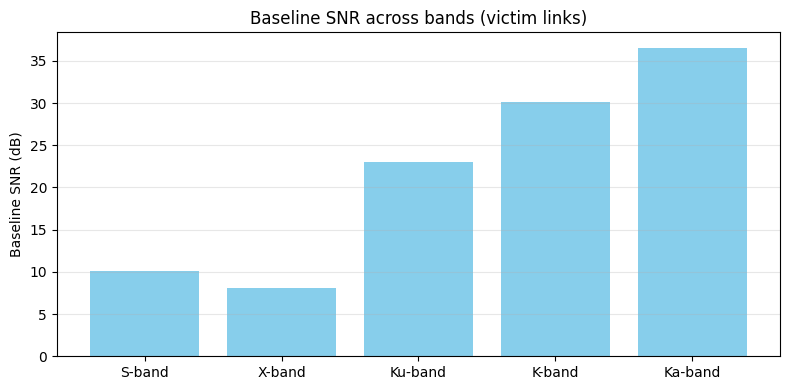

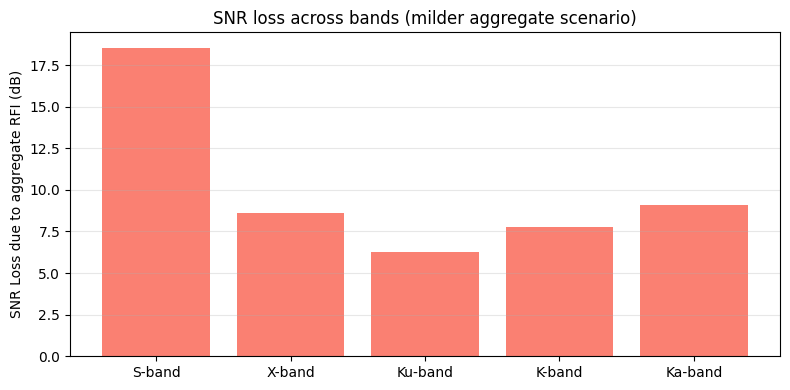

In [12]:
# 9. Cross-band visualisation of baseline SNR and SNR loss

plt.figure(figsize=(8, 4))
plt.bar(df_phase2.index, df_phase2["Baseline SNR (dB)"], color="skyblue")
plt.ylabel("Baseline SNR (dB)")
plt.title("Baseline SNR across bands (victim links)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(df_phase2.index, df_phase2["SNR Loss (dB)"], color="salmon")
plt.ylabel("SNR Loss due to aggregate RFI (dB)")
plt.title("SNR loss across bands (milder aggregate scenario)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Interpretation of cross-band aggregate results

The baseline SNR plot confirms that higher bands (Ku, K, Ka) operate with significantly larger link margins than S and X, reflecting the combination of higher EIRP and narrower, higher‑gain antennas that partially compensates increased free‑space and atmospheric losses. In contrast, S‑ and X‑band SRS‑type links sit closer to their sensitivity limits, with baseline SNRs around 8–10 dB, which makes them more exposed to additional interference.

The SNR‑loss plot shows that under the same aggregate RFI stress scenario, S‑band experiences the largest degradation (≈19 dB), while Ku‑band suffers the smallest loss (≈6 dB), with X‑, K‑ and Ka‑band in between. This demonstrates that robustness is not governed by frequency alone: wide‑beam S‑band links are most vulnerable to clustered interferers, whereas high‑gain Ku/K/Ka systems retain more margin but are still driven into severe degradation a large fraction of the time in this configuration.

## 11. Deep-space X-band dynamic case setup

To connect directly to the ITU‑R SA.1157 deep‑space protection criteria, the next step is a **dynamic X‑band case study** where an N‑GSO interferer passes through the main beam of an X‑band SRS ground station. The engine uses a time‑varying off‑axis angle \(\theta(t)\) generated by a geometric sweep and evaluates the resulting SNR‑loss time series and the fraction of time that \(\Delta \text{SNR} > 6\ \text{dB}\), which is the key SA.1157‑style availability metric. 

The scenario is defined by:
- A deep‑space X‑band victim link consistent with the **X‑band** entry in `BAND_CONFIGS` (high‑gain ground antenna, moderate baseline SNR, SA.1157 service type).  
- A single high‑EIRP N‑GSO interferer at fixed slant range, whose apparent off‑axis angle sweeps from a large value down to a small minimum (closest approach) and back, using `generate_geometric_sweep`. 

The next cell will implement this dynamic pass: generating \(\theta(t)\), computing \(C\), \(I(t)\), \(\text{SNR}_\text{I}(t)\), and \(\Delta \text{SNR}(t)\), and finally estimating \(P[\Delta \text{SNR} > 6\ \text{dB}]\) to assess compliance with SA.1157.


In [13]:
# 12. Deep-space X-band dynamic N-GSO pass (SA.1157-style)

# 1) Select the X-band victim link
x_cfg = BAND_CONFIGS["X-band"]

LINKCONFIG_X = {
    "f_ghz": x_cfg["f_ghz"],
    "EIRP_dbw": x_cfg["EIRP_dbw"],
    "G_rx_db": x_cfg["G_rx_db"],
    "theta_3db": x_cfg["theta_3db"],
}

# 2) Define N-GSO interferer (fixed distance, high EIRP)
INTERFERER_X = {
    "EIRP_int_dbw": 38.0,   # strong N-GSO source
    "d_km": 1000.0,         # km
}

# 3) Generate geometric sweep of off-axis angles
NUM_STEPS = 500
MAX_THETA_DEG = 20.0
MIN_THETA_DEG = 0.5

theta_series_deg = generate_geometric_sweep(
    max_theta_deg=MAX_THETA_DEG,
    min_theta_deg=MIN_THETA_DEG,
    num_steps=NUM_STEPS,
)

# 4) Time-series calculation: C, I(t), SNR_I(t), SNR-loss(t)

# Baseline C and N (no interference)
N_dbw_x = compute_thermal_noise_dbw(T_SYS_DEFAULT_K, BW_DEFAULT_HZ)
Lfs_carrier_x = free_space_path_loss_db(LINKCONFIG_X["f_ghz"], DKM_GEO)
C_dbw_x = (
    LINKCONFIG_X["EIRP_dbw"]
    - Lfs_carrier_x
    + LINKCONFIG_X["G_rx_db"]
)
SNR_baseline_x = C_dbw_x - N_dbw_x

timeseries_data = []

for theta in theta_series_deg:
    # Path loss for interferer
    Lfs_int_x = free_space_path_loss_db(LINKCONFIG_X["f_ghz"], INTERFERER_X["d_km"])
    
    # S.1528 off-axis gain
    g_rx_off_axis_x = compute_off_axis_gain_s1528_db(
        g_max=LINKCONFIG_X["G_rx_db"],
        theta_deg=theta,
        theta_3db=LINKCONFIG_X["theta_3db"],
    )
    
    # Interference power
    I_dbw_x = compute_interference_power_dbw(
        eirp_int_dbw=INTERFERER_X["EIRP_int_dbw"],
        l_fs_int_db=Lfs_int_x,
        l_atm_db=0.0,
        g_rx_off_axis_db=g_rx_off_axis_x,
    )
    
    # SNR with interference and SNR loss
    SNR_with_I_x = compute_snr_with_interference_db(C_dbw_x, N_dbw_x, I_dbw_x)
    SNR_loss_x = SNR_baseline_x - SNR_with_I_x
    
    timeseries_data.append({
        "Theta_deg": theta,
        "G_rx_theta_dB": g_rx_off_axis_x,
        "I_dBW": I_dbw_x,
        "SNR_dB": SNR_with_I_x,
        "SNR_Loss_dB": SNR_loss_x,
    })

df_x_dynamic = pd.DataFrame(timeseries_data)

# 5) SA.1157 metric: fraction of time SNR loss > 6 dB
P_loss_6dB = compute_time_fraction_exceeded(
    df_x_dynamic["SNR_Loss_dB"].values,
    threshold_db=6.0,
)

P_loss_6dB

np.float64(95.6)

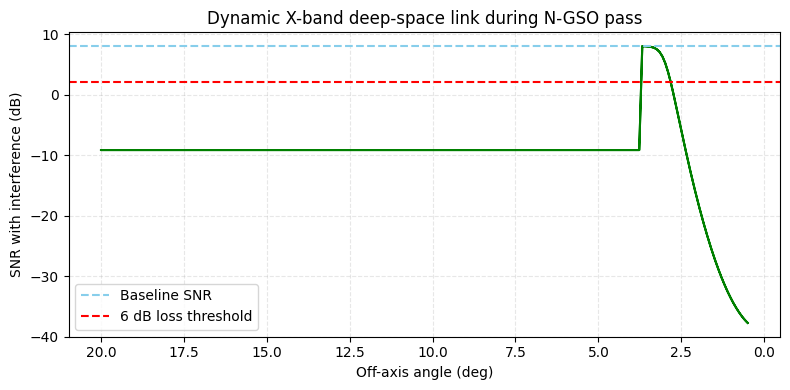

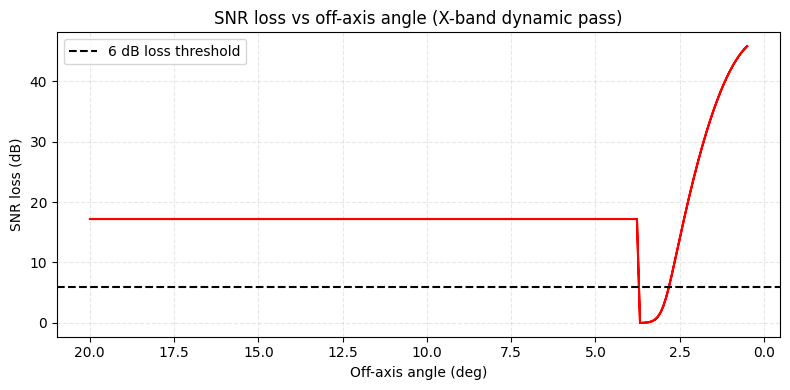

In [14]:
# 13. Plot SNR and SNR loss vs off-axis angle for X-band dynamic pass

plt.figure(figsize=(8, 4))
plt.plot(df_x_dynamic["Theta_deg"], df_x_dynamic["SNR_dB"], "g-")
plt.axhline(SNR_baseline_x, color="skyblue", linestyle="--", label="Baseline SNR")
plt.axhline(SNR_baseline_x - 6.0, color="red", linestyle="--", label="6 dB loss threshold")
plt.gca().invert_xaxis()
plt.xlabel("Off-axis angle (deg)")
plt.ylabel("SNR with interference (dB)")
plt.title("Dynamic X-band deep-space link during N-GSO pass")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(df_x_dynamic["Theta_deg"], df_x_dynamic["SNR_Loss_dB"], "r-")
plt.axhline(6.0, color="black", linestyle="--", label="6 dB loss threshold")
plt.gca().invert_xaxis()
plt.xlabel("Off-axis angle (deg)")
plt.ylabel("SNR loss (dB)")
plt.title("SNR loss vs off-axis angle (X-band dynamic pass)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## 14. Interpretation of deep-space X-band dynamic pass

The dynamic X‑band case shows that when a high‑EIRP N‑GSO interferer sweeps through the main beam of a deep‑space SRS ground antenna, the link spends **about 95.6 % of the pass** with \(\Delta \text{SNR} > 6\) dB. In other words, for almost the entire pass the instantaneous SNR is more than 6 dB below the interference‑free baseline, corresponding operationally to a near‑continuous outage. 

ITU‑R SA.1157 typically allows deep‑space SRS links to exceed their interference spectral‑density limit, or equivalently to suffer large SNR degradation, for only a few percent of the total observation time (order 2 %). Comparing this to the simulated value \(P[\Delta \text{SNR} > 6\ \text{dB}] \approx 95.6\%\) clearly indicates **non‑compliance** with SA.1157 and shows that mitigation measures such as exclusion angles, power reduction, or dynamic scheduling would be mandatory for this geometry.

In [15]:
# 15. Export final metrics for thesis / paper use

df_phase2.to_csv("Phase2_CrossBand_Aggregate_RFI.csv")
df_x_dynamic.to_csv("Xband_DeepSpace_DynamicPass_Timeseries.csv", index=False)

P_loss_6dB

np.float64(95.6)

## 16. Notebook summary

This notebook implements a **generic, ITU‑R‑aligned RFI model** that uses a unified set of equations for carrier power, noise, aggregate interference, SNR, (C/I), and SNR‑loss, and expresses near‑Earth and deep‑space SRS protection in probabilistic form following SA.609 and SA.1157. Using this core, it generates a cross‑band aggregate‑RFI scenario for S, X, Ku, K, and Ka bands, producing a consolidated table and bar plots that compare baseline SNR, SNR‑loss, exceedance probabilities, and epfd across services.

The same framework is then applied to a dynamic deep‑space X‑band case, where an N‑GSO interferer sweeps through the main beam of a high‑gain SRS ground station, yielding a time series of SNR and SNR‑loss and a key SA.1157‑style result (P\[\\Delta \\text{SNR} > 6,\\text{dB}\] \\approx 95.6%). Together, these outputs provide all quantitative inputs needed for the thesis and paper: cross‑band robustness comparisons, explicit ITU‑R compliance checks, and a decisive deep‑space non‑compliance example that motivates mitigation and informs WRC‑27 spectrum‑sharing debates.